In [1]:
from io import open
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import os, string, random, time, math 
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from IPython.display import clear_output

In [2]:
print(torch.cuda.is_available())

True


# **Encoding**

In [3]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad = '-PAD-'
engdic = {pad : 0}
for index ,alpha in enumerate(eng_alphabets):
  engdic[alpha] = index+1
print(engdic)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [4]:
#Telugu unicode for hex range is 3072:3199
tel_alphabets = [chr(alpha) for alpha in range(3072,3199)]
tel_alphabets.append(chr(8204))
tel_alphabets.append(chr(8205))
tel_size = len(tel_alphabets)
teldic = {pad : 0}
for index ,alpha in enumerate(tel_alphabets):
  teldic[alpha] = index+1
print(teldic)  


{'-PAD-': 0, 'ఀ': 1, 'ఁ': 2, 'ం': 3, 'ః': 4, 'ఄ': 5, 'అ': 6, 'ఆ': 7, 'ఇ': 8, 'ఈ': 9, 'ఉ': 10, 'ఊ': 11, 'ఋ': 12, 'ఌ': 13, '\u0c0d': 14, 'ఎ': 15, 'ఏ': 16, 'ఐ': 17, '\u0c11': 18, 'ఒ': 19, 'ఓ': 20, 'ఔ': 21, 'క': 22, 'ఖ': 23, 'గ': 24, 'ఘ': 25, 'ఙ': 26, 'చ': 27, 'ఛ': 28, 'జ': 29, 'ఝ': 30, 'ఞ': 31, 'ట': 32, 'ఠ': 33, 'డ': 34, 'ఢ': 35, 'ణ': 36, 'త': 37, 'థ': 38, 'ద': 39, 'ధ': 40, 'న': 41, '\u0c29': 42, 'ప': 43, 'ఫ': 44, 'బ': 45, 'భ': 46, 'మ': 47, 'య': 48, 'ర': 49, 'ఱ': 50, 'ల': 51, 'ళ': 52, 'ఴ': 53, 'వ': 54, 'శ': 55, 'ష': 56, 'స': 57, 'హ': 58, '\u0c3a': 59, '\u0c3b': 60, '\u0c3c': 61, 'ఽ': 62, 'ా': 63, 'ి': 64, 'ీ': 65, 'ు': 66, 'ూ': 67, 'ృ': 68, 'ౄ': 69, '\u0c45': 70, 'ె': 71, 'ే': 72, 'ై': 73, '\u0c49': 74, 'ొ': 75, 'ో': 76, 'ౌ': 77, '్': 78, '\u0c4e': 79, '\u0c4f': 80, '\u0c50': 81, '\u0c51': 82, '\u0c52': 83, '\u0c53': 84, '\u0c54': 85, 'ౕ': 86, 'ౖ': 87, '\u0c57': 88, 'ౘ': 89, 'ౙ': 90, 'ౚ': 91, '\u0c5b': 92, '\u0c5c': 93, '\u0c5d': 94, '\u0c5e': 95, '\u0c5f': 96, 'ౠ': 97, 'ౡ': 98, 'ౢ': 99, 

# **Preprocessing**

In [5]:
X=[]
Y=[]
with open("v1.en_tel_wiki_titles.txt","r") as f:
  for line in f:
    line = line.split()
    eng = line[0].strip().upper()
    tel = line[1].strip()
    X.append(eng)
    Y.append(tel)

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [7]:
for i in range(3):
  print(X_train[i],Y_train[i])

MARTURU మర్టూరు
AISHWARYA ఐశ్వర్య
MERKEL మెర్కెల్


# **Dataset loading**

In [8]:
from torch.utils.data import Dataset

class Dataloader(Dataset):
  def __init__(self, a ,b):
    self.tel_words, self.eng_words = a,b
    self.shuffle_indices  = list(range(len(self.tel_words)))
    random.shuffle(self.shuffle_indices)
    self.shuffle_start_index = 0
  def __len__(self):
    return len(self.tel_words)

  def __getitem__(self, idx):
    return self.tel_words[idx], self.eng_words[idx]

  def get_random_sample(self):
    return self.getitem__(np.random.randint(len(self.tel_words)))

  def get_batch_from_array(self, batch_size, array):
    end = self.shuffle_start_index + batch_size
    batch = []
    if end >= len(self.tel_words):
      batch = [array[i] for i in self.shuffle_indices[0:end%len(self.tel_words)]]
      end = len(self.tel_words)
    return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
  
  def get_batch(self, batch_size, postprocess=True):
    tel_batch = self.get_batch_from_array(batch_size, self.tel_words)
    eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
    self.shuffle_start_index += batch_size +1

    if  self.shuffle_start_index >= len(self.tel_words):
      random.shuffle(self.shuffle_indices)
      self.shuffle_start_index = 0

    return tel_batch , eng_batch


   

In [9]:
train_data = Dataloader(Y_train, X_train)
test_data = Dataloader(Y_test, X_test)

In [10]:
def word_rep(word, dic, device = 'cpu'):
  word_rep = torch.zeros(len(word)+1, 1, len(dic)).to(device)
  for letter_index , letter in enumerate(word):
    pos = dic[letter]
    word_rep[letter_index][0][pos] = 1
  pad_pos = dic[pad]
  word_rep[letter_index+1][0][pad_pos] = 1
  return word_rep  

In [11]:
def gt_rep(word, dic, device = 'cpu'):
  rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
  for letter_index, letter in enumerate(word):
    pos = dic[letter]
    rep[letter_index][0] = pos
  rep[letter_index+1][0] = dic[pad]
  return rep

In [12]:
c=0
for i in Y:
  c=c+1
  try:
    a = word_rep(i,teldic)
  except:
    print(c)

In [13]:
sample = word_rep("పసునూరి",teldic)
print(sample)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.]]])


In [14]:
sample2 = gt_rep("NARE",engdic)
print(sample2)

tensor([[14],
        [ 1],
        [18],
        [ 5],
        [ 0]])


# **Network Architecture(using GRUs) with Attention**

In [15]:
Max = 30
class Transliteration_Encoder_Decoder(nn.Module):
  
  def __init__(self, input_size, hidden_size, output_size):
    super(Transliteration_Encoder_Decoder,self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size

    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)

    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)

    self.U = nn.Linear(self.hidden_size,self.hidden_size)
    self.W = nn.Linear(self.hidden_size,self.hidden_size)
    self.attn = nn.Linear(self.hidden_size, 1)
    self.out2hidden = nn.Linear(self.output_size, self.hidden_size)


  def forward(self, input_, max_char = Max, device = 'cpu', gt=None):
    # encoder
    eout, hidden = self.encoder_rnn_cell(input_)
    eout = eout.view(-1,self.hidden_size)
    # decoder
    decoder_state = hidden
    decoder_input = torch.zeros(1, 1, self.output_size).to(device)
   
    outputs = []
    U = self.U(eout)

    for i in range(max_char):

      W = self.W(decoder_state.view(1,-1).repeat(eout.shape[0], 1))
      V = self.attn(torch.tanh(U + W))
      attn_weights = F.softmax(V.view(1,-1), dim = 1)

      attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                               eout.unsqueeze(0))

      embedding = self.out2hidden(decoder_input)
      decoder_input = torch.cat((embedding[0], attn_applied[0]),1).unsqueeze(0)

      out , decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
      
      out = self.h2o(decoder_state)
      out = self.softmax(out)
      outputs.append(out.view(1,-1))

      #giving output of one nn to next nn

      idx= torch.argmax(out,2,keepdim=True)
      if not gt is None:
        idx = gt[i].reshape(1,1,1)
      one_hot = torch.zeros(out.shape, device = device)
      one_hot.scatter_(2,idx,1)

      decoder_input = one_hot.detach()
    return outputs

In [16]:
net = Transliteration_Encoder_Decoder(len(teldic),256,len(engdic))

In [17]:
def infer(net, name,n, device):
  net.eval().to(device)
  name_ohe = word_rep(name,teldic,device)
  output = net(name_ohe,n,device)
  return output

In [31]:
out = infer(net , "ఎల",10,device_gpu)

In [32]:
for i in range(len(out)):
  print(out[i].shape, list(engdic.keys())[list(engdic.values()).index(torch.argmax(out[i]))])

torch.Size([1, 27]) E
torch.Size([1, 27]) L
torch.Size([1, 27]) A
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-


# **Training**

In [20]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacherforce = False):
  
  net.train().to(device)
  opt.zero_grad()
  tel_batch, eng_batch = train_data.get_batch(batch_size)

  total_loss = 0
  for i in range(batch_size):
    input = word_rep(tel_batch[i], teldic, device)
    gt = gt_rep(eng_batch[i], engdic, device)
    outputs = net(input, gt.shape[0], device, gt = gt if teacherforce else None)

    for index, output in enumerate(outputs):
      loss = criterion(output, gt[index]) / batch_size
      loss.backward(retain_graph = True)
      total_loss += loss
  opt.step()
  return total_loss/batch_size    



In [21]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10,momentum = 0.9, display_freq = 5, device = 'cpu'):

  net = net.to(device)
  criterion = nn.NLLLoss(ignore_index = -1)
  opt = optim.Adam(net.parameters(), lr=lr)
  teacher_force_upto = n_batches//3

  loss_arr = np.zeros(n_batches+1)

  for i in range(n_batches):
    loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacherforce = i<teacher_force_upto)) /(i+1)
    if i%display_freq == display_freq-1:
      clear_output(wait=True)
      print('Iteration', i, 'Loss', loss_arr[i])
      plt.figure()
      plt.plot(loss_arr[1:i], '-*')
      plt.xlabel('Iteration')
      plt.ylabel('Loss')
      plt.show()
      print('\n\n')
  torch.save(net, 'model.pt')
  return loss_arr

Iteration 1999 Loss 0.110249362885952


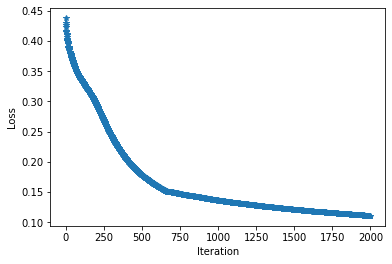

array([0.        , 0.42652631, 0.43753999, ..., 0.11027178, 0.11024936,
       0.11022153])

In [22]:
net = Transliteration_Encoder_Decoder(len(teldic),256,len(engdic))
train_setup(net, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device= device_gpu)

In [23]:
def calc_accuracy(net, device = 'cpu'):
  net = net.eval().to(device)
  predictions = []
  accuracy = 0
  for i in range(len(test_data)):
    tel, eng = test_data[i]
    gt = gt_rep(eng, engdic, device)
    outputs = infer(net, tel,gt.shape[0], device)
    correct = 0
    for index,out in enumerate(outputs):
      val, indices = out.topk(1)
      eng_pos = indices.tolist()[0]
      if eng_pos[0] == gt[index][0]:
        correct += 1
    accuracy += correct/gt.shape[0]
  accuracy /= len(test_data)
  return accuracy

In [24]:
accuracy = calc_accuracy(net) *100
print("Accuracy = ",accuracy)

Accuracy =  78.62072014801839
